# Libraries

In [0]:
'------------------------Libraries----------------------------'
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
import itertools
from torch.autograd import Variable
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load and Transform Data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Test  Train  Validation
train data 6200
Train Data Classes: 
['covid-19', 'normal', 'pneumonia'] 

valid data 628
Validation Data Classes: 
['covid', 'normal', 'pneumonia'] 

test data 629 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


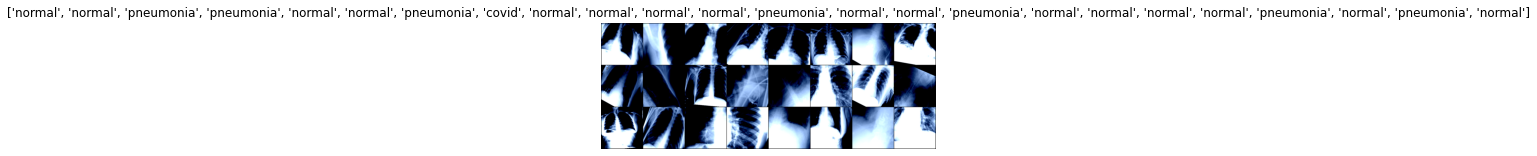

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "/content/gdrive/My Drive/Assignment05/Assignment05_part2/A_05_Part_02_Dataset"
import os
os.chdir(data_dir)
!ls
'--------------transforms training data and testing data-------------'
  #Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std = [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean =[0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean =[0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225])])
#pass transform here-in
train_data = datasets.ImageFolder( data_dir + "/Train", transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + "/Test", transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=24, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=24, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=24, shuffle=True)
print('train data',len(train_data))
print("Train Data Classes: ")
class_names = train_data.classes
print(class_names,"\r\n")

print('valid data',len(valid_data))
print("Validation Data Classes: ")
class_names = valid_data.classes
print(class_names,"\r\n")


# print("Test Data Classes: ")
print('test data',len(test_data),"\r\n")
# class_names = test_data.classes
# print(class_names,"\r\n")

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)


In [0]:
'-------------------Utilities--------------------------'

'---------------------------------Confusion matrix--------------------------------------'

def conf_matrix(model,loader):
  Y_act_test = np.array([])
  Y_pred_test = np.array([])
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      Y_act_test = np.append( Y_act_test , np.array(labels.cpu()) )
      Y_pred_test = np.append( Y_pred_test , np.array(predicted.cpu()) )
  print('F1 score:', f1_score(Y_act_test, Y_pred_test, average ='weighted'))
  matrix = confusion_matrix(Y_act_test, Y_pred_test)
  df_cm = pd.DataFrame(matrix, ['covid', 'normal', 'pneumonia'], ['covid', 'normal', 'pneumonia'])
  plt.figure(figsize=(5,4))
  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 13})
"--------------Ground truth and predicted--------"
def gtp(model,loader):
  dataiter1 = iter(trainloader)
  images, labels = dataiter1.next()
  show_databatch(images, labels)

  images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
# images, labels = images.cuda(), labels.cuda()
  if torch.cuda.is_available():
      model.cuda()
  outputs = model(images)
# Ground truth and predicted
  _, predicted = torch.max(outputs, 1)

  print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
  print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))


########### For Focal Loss ################

def one_hot(index, classes):
    size = index.size() + (classes,)
    view = index.size() + (1,)

    mask = torch.Tensor(*size).fill_(0)
    index = index.view(*view)
    ones = 1.

    if isinstance(index, Variable):
        ones = Variable(torch.Tensor(index.size()).fill_(1))
        # mask = Variable(mask, volatile=index.volatile)

    return mask.scatter_(1, index, ones)

class FocalLoss(nn.Module):

    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target):

        y = one_hot(target, input.size(-1))
        # logit = F.softmax(input, dim=-1)
        logit = torch.sigmoid(input)

        logit = logit.clamp(self.eps, 1. - self.eps)

        BCEwithLogit_loss = -1 * y * torch.log(logit) # cross entropy
        Focal_loss = BCEwithLogit_loss * (1 - logit) ** self.gamma # focal loss

        return Focal_loss.sum()

############ For With BCEwithLogits ################
# def to_one_hot(x, C=2, tensor_class=torch.FloatTensor):
#     """ One-hot a batched tensor of shape (B, ...) into (B, C, ...) """
#     x_one_hot = tensor_class(x.size(0), C, *x.shape[1:]).zero_()
#     x_one_hot = x_one_hot.scatter_(1, x.unsqueeze(1), 1)
#     return x_one_hot

def one_hot_(label):
  label = label.long()
  # print(label.size())
  labels = torch.eye(3)
  labels[0] = labels[0]+labels[2]

  return labels[label]

# Train Model

In [0]:

device = torch.device( "cuda:0" if torch.cuda.is_available() else"cpu")
def train_model(model, Epochs, criterion, optimizer,saved_model_name,model_name):
 

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
# "cuda:0" if torch.cuda.is_available() else
  model.to(device)
  model.train()
  e_lr = []
  epoch_train_acc = []
  epoch_train_loss = []
  epoch_valid_acc= []
  epoch_valid_loss = []

  pbar = tqdm(enumerate(trainloader),position=0, leave=True)
  e = []
  save_path = '/content/gdrive/My Drive/Assignment05/Assignment05_part2/Results Plots/'
      
  for epoch in range(Epochs):  # loop over the dataset multiple times
  

      valid_accuracy =  0.0
      train_accuracy = 0.0
      correct = 0
      total = 0
    # loss_values = []
      running_loss = 0.0
    # vrunning_loss = 0.0
      valid_correct = 0
      valid_total = 0
      v_loss = 0.0
      correct_labels = []
      predicted_labels = []
###############################Train data ################################ 
    
      for i, data in pbar:
        # get the inputs
        inputs, labels = data
        labels = one_hot_(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = model(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update


        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predicted = one_hot_(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = (100 * correct / total)
       
        _loss =  100. * i / len(trainloader)
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.3f}%'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
               _loss,
               loss.data,
               accuracy))
      
###############################Validation data ################################ 
    
        with torch.no_grad():
          for data in validloader:
            images, labels = data
            labels = one_hot_(labels)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted = one_hot_(predicted)
            valid_total += labels.size(0)
            valid_correct += (predicted == labels).sum().item()
            v_loss += criterion(outputs, labels).item()
       
        vaccuracy = (100 * valid_correct / valid_total)
      
###############################Test data ################################ 

        with torch.no_grad():
          for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            t_loss += criterion(outputs, labels).item()
        
        taccuracy = (100 * test_correct / test_total)  

############################### Print Accuracy and Loss ################################ 

      epoch_train_acc.append(accuracy)
      epoch_train_loss.append(running_loss)
      epoch_valid_acc.append(vaccuracy)
      epoch_valid_loss.append(v_loss)
      epoch_test_acc.append(taccuracy)
      epoch_test_loss.append(t_loss)
  print("\r\n""\r\n""Training Loss is :",float(loss.data),"at epoch", epoch)
  print('Training Accuracy : %d %%' %  accuracy,"at ecpoch",epoch )
  
  
      
  print("\r\n""Validation Loss is : ", v_loss,"at epoch", epoch)
  print('Validation Accuracy : %d %%' %  vaccuracy,"at ecpoch",epoch )
  
  plt.figure()
# Loss Plots of Training and Validation Data
  plt.plot(range(Epochs),epoch_train_loss,color='g',label='Loss per ecpoch of Train')
  plt.plot(range(Epochs),epoch_valid_loss,color='k',label='Loss per epoch of Validation')
  plt.title('Loss Curves')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  plt.savefig(os.path.join(save_path,'Train and Validation Loss Curve.png'),bbox_inches='tight')


# Accuracy Plots of Training and Validation Data
  plt.plot(range(Epochs),epoch_train_acc,color='g',label='Accuracy per ecpoch of Train')
  plt.plot(range(Epochs),epoch_valid_acc,color='k',label='Accuracy per ecpoch of Validation')
  plt.title('Accuracy Curves')
  plt.xlabel('epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  
  plt.savefig(os.path.join(save_path,'Train and Validation Accuracy Curve.png'),bbox_inches='tight')

############################### save Model  ################################ 
  model = torch.save(model.state_dict(),saved_model_name)
  model= (torch.load(saved_model_name)) 




# **With Focal Loss**

## Resnet18
### With batch size 32

In [0]:

# Load the pretrained model from pytorch
resnet18 = models.resnet18 (pretrained=True)

'----------Freeze training for all layers of resnet18-------'
# Freeze training for all layers
for param in resnet18.parameters():
    param.require_grad = False
# print (resnet18)

# Freezing all layers except last one
for param in resnet18.fc.parameters() :
    param.requires_grad = True


'______________Adding New Layers___________________'
num_features = resnet18.fc.in_features
fc_layers = nn.Sequential(
                nn.Linear(num_features, 850),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1,inplace = False),
                nn.Linear(850, 3),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1,inplace = False),
            )
resnet18.fc = fc_layers
'--------------------------------Loss fucntion and optimizer-----------------------------------------------------'
route = "/content/gdrive/My Drive/Assignment05/weights/"
saved_model_name = route +'res18_focal_loss.pth'
Epochs = 10
model_name= 'resnet18__FC_Only_with_FocalLoss'
# train_model(vgg16, Epochs, criterion, optimizer,saved_model_name,model_name)
# Loss and Optimizer
# '-----------Focal Loss---------'
criterion = FocalLoss(gamma=1) #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-5)  
model = resnet18
train_model(model, Epochs, criterion, optimizer,saved_model_name,model_name)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## Vgg16
### With batch size 64

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
# # '_________________ Adding Layer(FC LAYER)______________'
vgg16.classifier[0].out_features = 1500        # 75*10+100
vgg16.classifier[3].in_features = 1500
vgg16.classifier[3].out_features = 3

'--------------------------------Loss fucntion and optimizer-----------------------------------------------------'
route = "/content/gdrive/My Drive/Assignment05/weights/"
saved_model_name = route +'vgg16_focal_loss.pth'
Epochs = 5
model_name= 'Vgg16_entire_With_Focal_lOSS'
# train_model(vgg16, Epochs, criterion, optimizer,saved_model_name,model_name)
# Loss and Optimizer
# '-----------Focal Loss---------'
criterion = FocalLoss(gamma=0.5) #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=1e-3)  
model = vgg16
train_model(model, Epochs, criterion, optimizer,saved_model_name,model_name)

# Without Focal Loss
## Resnet18
### With batch size 24

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18 (pretrained=True)
# print(resnet18)

'______________Adding New Layers___________________'
num_features = resnet18.fc.in_features
fc_layers = nn.Sequential(
                nn.Linear(num_features, 850),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1,inplace = False),
                nn.Linear(850,3 )
            )
resnet18.fc = fc_layers
print(resnet18.fc)

'--------------------------------Loss fucntion and optimizer-----------------------------------------------------'
route = "/content/gdrive/My Drive/Assignment05/weights/"
saved_model_name = route +'res18_Without_Focal_Loss.pth'
Epochs = 5
model_name= 'resnet18_entire_Without_Focal_Loss'

# '-----------BCEWITHLOGITS Loss---------'
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD (resnet18.parameters(), lr=0.00001, momentum= 0.9)
model = resnet18
train_model(model, Epochs, criterion, optimizer,saved_model_name,model_name)  

## VGG16
### With batch size 24

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
'----------Freeze training for all layers of Features-------'
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = True
# print (vgg16.features)

'----------Freeze training for all layers of classifier-------'
# Freezing all layers except last one
for param in vgg16.classifier.parameters() :
    param.requires_grad = False
print(vgg16.classifier)

'___________ Removing Last Layer(FC LAYER)______________'
um_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
# print(features)

'_________________ Adding Last Layer(1 FC LAYER)______________'
features.extend([nn.Linear(4096, 850,bias = True)])
features.extend([nn.ReLU(inplace = True)])
'________________ Adding Last Layer(2 FC LAYER)______________'
features.extend([nn.Linear(850, len(class_names),bias = True)])

vgg16.classifier[0].out_features = 850        # 75*10+100
vgg16.classifier[3].in_features = 850
vgg16.classifier[3].out_features = 3
# vgg16.classifier[6].out_features = 3


'________Checking New layers added or not___________'
vgg16.classifier = nn.Sequential(*features)
print(vgg16.classifier)

'--------------------------------Loss fucntion and optimizer-----------------------------------------------------'
route = "/content/gdrive/My Drive/Assignment05/Assignment05_part2/weights/"
saved_model_name = route +'vgg16_Without_Focal_LOss.pth'
Epochs = 5
model_name = 'Vgg_FC_only_without_FocalLOss1'


# '-----------BCEWITHLOGITS Loss---------'
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD (vgg16.parameters(), lr=0.001, momentum= 0.9)   

model = vgg16
train_model(model, Epochs, criterion, optimizer,saved_model_name,model_name)  

# Confusion Matrix and Groun Truth


________Train Confusion Matrix, Precision, Recall, F1-Score__________

resnet18_entire_withFocalLoss_Train_confusion_Matrix
F1 score: 0.7329962676900846


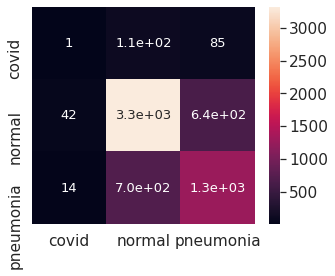

In [0]:
model = resnet18
print("\r\n""________Train Confusion Matrix, Precision, Recall, F1-Score__________""\r\n")
print("resnet18_entire_withFocalLoss_Train_confusion_Matrix")
conf_matrix(model,trainloader)


________Train Confusion Matrix, Precision, Recall, F1-Score__________

resnet18_entire_withFocalLoss_Valid_confusion_Matrix
F1 score: 0.7737092499619319


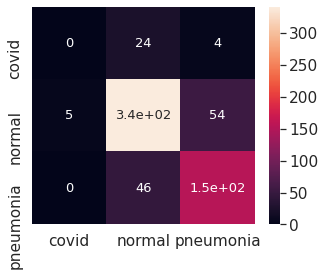

In [0]:
print("\r\n""________Train Confusion Matrix, Precision, Recall, F1-Score__________""\r\n")
print("resnet18_entire_withFocalLoss_Valid_confusion_Matrix")
conf_matrix(model,validloader)

--------------Train Ground truth and predicted with Focalloss--------------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


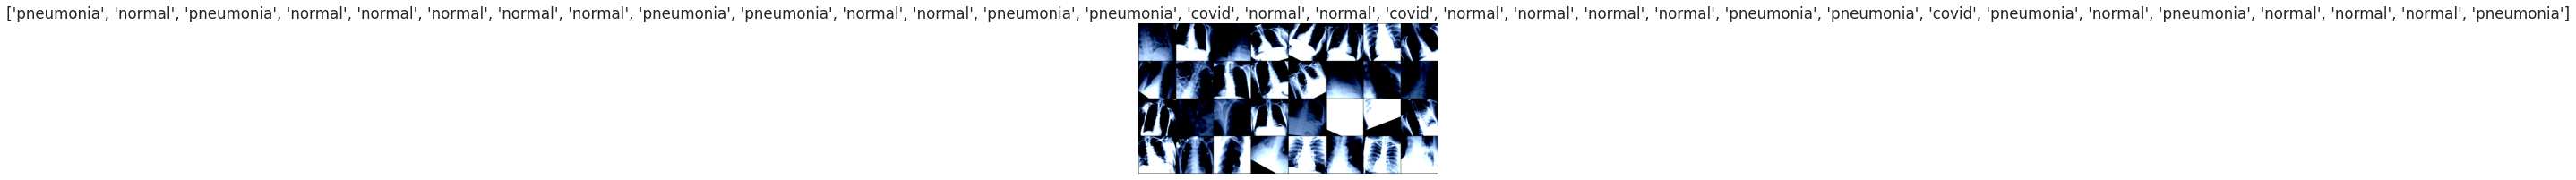

Predicted:  pneumonia normal pneumonia normal normal normal normal normal pneumonia pneumonia normal normal normal pneumonia normal normal normal pneumonia normal normal normal normal normal normal normal pneumonia normal pneumonia normal normal normal normal
Ground Truth:  pneumonia normal pneumonia normal normal normal normal normal pneumonia pneumonia normal normal pneumonia pneumonia covid normal normal covid normal normal normal normal pneumonia pneumonia covid pneumonia normal pneumonia normal normal normal pneumonia

--------------Validation  Ground truth and predicted with Focalloss--------------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


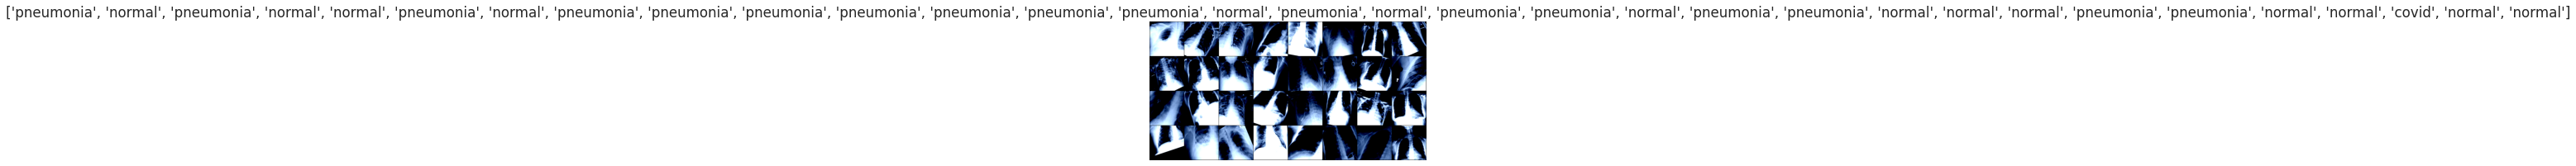

Predicted:  normal pneumonia pneumonia normal normal pneumonia normal normal pneumonia normal pneumonia normal pneumonia pneumonia normal normal normal normal pneumonia normal pneumonia normal pneumonia normal normal normal pneumonia normal normal normal pneumonia normal
Ground Truth:  pneumonia normal pneumonia normal normal pneumonia normal pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia pneumonia normal pneumonia normal pneumonia pneumonia normal pneumonia pneumonia normal normal normal pneumonia pneumonia normal normal covid normal normal


In [0]:
print("--------------Train Ground truth and predicted with Focalloss--------------""\r\n")
gtp(resnet18,trainloader)

print("\r\n""--------------Validation  Ground truth and predicted with Focalloss--------------""\r\n")
gtp(resnet18,validloader)

# Test Data

In [0]:
def to_one_hot(x, C=2, tensor_class=torch.FloatTensor):
    """ One-hot a batched tensor of shape (B, ...) into (B, C, ...) """
    x_one_hot = tensor_class(x.size(0), C, *x.shape[1:]).zero_()
    x_one_hot = x_one_hot.scatter_(1, x.unsqueeze(1), 1)
    return x_one_hot

device = torch.device( "cuda:0" if torch.cuda.is_available() else"cpu")
model = resnet18
model.to(device)
model.eval()

pred = []

###############################Test data ################################ 
for data in testloader:
  images, labels = data
  num_classes = 3
  labels = to_one_hot(labels, C=num_classes)
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  outputs = torch.sigmoid(outputs)

  y_hat = torch.Tensor.cpu(outputs>0.5).int().numpy()
  y_hat[:,[1,2]] = y_hat [:,[2,1]]
  pred.extend(y_hat)

df = pd.DataFrame(pred)
df[-1] = pd.Series([record[0].split('/')[-1] for record in testloader.dataset.samples])

In [0]:
p = '/content/gdrive/My Drive/Assignment05/Assignment05_part2/Note book'
df.to_csv(p+'/cov_results.csv',header=False)

## Resnet18_FC_Only_FocallLoss
### With batch size 32

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18 (pretrained=True)
# print(resnet18)

'______________Adding New Layers___________________'
num_features = resnet18.fc.in_features
fc_layers = nn.Sequential(
                nn.Linear(num_features, 500),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.1,inplace = False),
                nn.Linear(500,350 )
            )
resnet18.fc = fc_layers
print(resnet18.fc)

'--------------------------------Loss fucntion and optimizer-----------------------------------------------------'
route = "/content/gdrive/My Drive/Assignment05/weights/"
saved_model_name = route +'resnet18_entire.pth'
Epochs = 5
model_name= 'resnet18_entire_'
# train_model(vgg16, Epochs, criterion, optimizer,saved_model_name,model_name)
# Loss and Optimizer
# '-----------Focal Loss---------'
criterion = FocalLoss(gamma=2) #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)  

Sequential(
  (0): Linear(in_features=512, out_features=500, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=500, out_features=350, bias=True)
)


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.000000	Accuracy: 63.758%: : 97it [2:14:16, 83.06s/it]



Training Loss is : 3.3721902223740607e-13 at epoch 4
Training Accuracy : 63 % at ecpoch 4

Validation Loss is :  0.0 at epoch 4
Validation Accuracy : 63 % at ecpoch 4


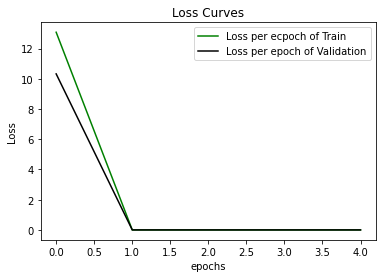

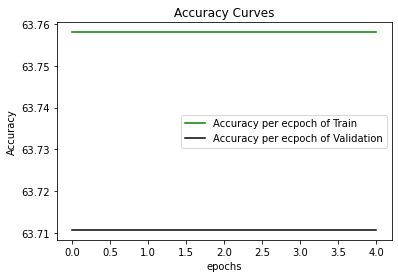

<Figure size 432x288 with 0 Axes>

In [0]:
device = torch.device( "cuda:0" if torch.cuda.is_available() else"cpu")
model = resnet18
model.to(device)
model.train()
e_lr = []
epoch_train_acc = []
epoch_train_loss = []
epoch_valid_acc= []
epoch_valid_loss = []
epoch_test_acc = []
epoch_test_loss =[]
pbar = tqdm(enumerate(trainloader))
e = []
save_path = '/content/gdrive/My Drive/Assignment05/Assignment05_part2/Results Plots/'
for epoch in range(Epochs):  # loop over the dataset multiple times
  valid_accuracy =  0.0
  train_accuracy = 0.0
  correct = 0
  total = 0
    # loss_values = []
  running_loss = 0.0
    # vrunning_loss = 0.0
  valid_correct = 0
  valid_total = 0
  v_loss = 0.0
  # test_correct = 0
  # test_total = 0
  # t_loss = 0.0
  correct_labels = []
  predicted_labels = []
###############################Train data ################################ 
  for i, data in pbar:
    inputs, labels = data
    labels = Variable(labels)
    # inputs = Variable(inputs.view(-1, 224*224))
    # print(labels.shape)
    # print(inputs.shape)
    inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
    optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
    
    outputs = model(inputs)               #----> forward pass
    loss = criterion(outputs, labels)   #----> compute loss
    loss.backward()                     #----> backward pass
    optimizer.step()                    #----> weights update
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    accuracy = (100 * correct / total)
       
    _loss =  100. * i / len(trainloader)
    pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.3f}%'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
               _loss,
               loss.data,
               accuracy))

   
##############################Validation data ################################ 
    
    with torch.no_grad():
      for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        valid_total += labels.size(0)
        valid_correct += (predicted == labels).sum().item()
        v_loss += criterion(outputs, labels).item()
       
    vaccuracy = (100 * valid_correct / valid_total)

############################## Print Accuracy and Loss ################################ 

     
  epoch_train_acc.append(accuracy)
  epoch_train_loss.append(running_loss)
  epoch_valid_acc.append(vaccuracy)
  epoch_valid_loss.append(v_loss)

print("\r\n""\r\n""Training Loss is :",float(loss.data),"at epoch", epoch)
print('Training Accuracy : %d %%' %  accuracy,"at ecpoch",epoch )

      
print("\r\n""Validation Loss is : ", v_loss,"at epoch", epoch)
print('Validation Accuracy : %d %%' %  vaccuracy,"at ecpoch",epoch )

############################## Print Accuracy and Loss Curves ################################ 
plt.figure()
# Loss Plots of Training and Validation Data
plt.plot(range(Epochs),epoch_train_loss,color='g',label='Loss per ecpoch of Train')
plt.plot(range(Epochs),epoch_valid_loss,color='k',label='Loss per epoch of Validation')
plt.title('Loss Curves')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(os.path.join(save_path,model_name+'Train and Validation Loss Curve.png'),bbox_inches='tight')


# Accuracy Plots of Training and Validation Data
plt.plot(range(Epochs),epoch_train_acc,color='g',label='Accuracy per ecpoch of Train')
plt.plot(range(Epochs),epoch_valid_acc,color='k',label='Accuracy per ecpoch of Validation')
plt.title('Accuracy Curves')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig(os.path.join(save_path,'Train and Validation Accuracy Curve.png'),bbox_inches='tight')


############################### save Model  ################################ 
model = torch.save(model.state_dict(),saved_model_name)
model= (torch.load(saved_model_name))



# Confusion Matrix and Groun Truth

In [0]:
'---------------------------------Confusion matrix--------------------------------------'
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
def conf_matrix(model,loader):
  Y_act_test = np.array([])
  Y_pred_test = np.array([])
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      Y_act_test = np.append( Y_act_test , np.array(labels.cpu()) )
      Y_pred_test = np.append( Y_pred_test , np.array(predicted.cpu()) )
  print('F1 score:', f1_score(Y_act_test, Y_pred_test, average ='weighted'))
  matrix = confusion_matrix(Y_act_test, Y_pred_test)
  df_cm = pd.DataFrame(matrix, ['covid', 'normal', 'pneumonia'], ['covid', 'normal', 'pneumonia'])
  plt.figure(figsize=(5,4))
  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 13})
"--------------Ground truth and predicted--------"
def gtp(model,loader):
  dataiter1 = iter(trainloader)
  images, labels = dataiter1.next()
  show_databatch(images, labels)

  images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
# images, labels = images.cuda(), labels.cuda()
  if torch.cuda.is_available():
      model.cuda()
  outputs = model(images)
# Ground truth and predicted
  _, predicted = torch.max(outputs, 1)

  print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
  print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))



________Train Confusion Matrix, Precision, Recall, F1-Score__________

resnet18_entire_withFocalLoss_Train_confusion_Matrix
F1 score: 0.5071240175708435


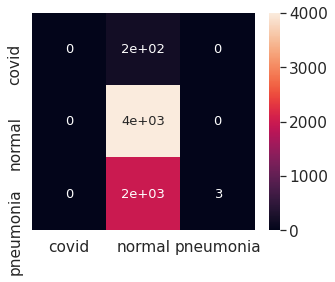

In [0]:
model = resnet18
print("\r\n""________Train Confusion Matrix, Precision, Recall, F1-Score__________""\r\n")
print("resnet18_entire_withFocalLoss_Train_confusion_Matrix")
conf_matrix(model,trainloader)


________Validation Confusion Matrix, Precision, Recall, F1-Score__________

resnet18_entire_withFocalLoss_Valid_confusion_Matrix
F1 score: 0.49567523358695387


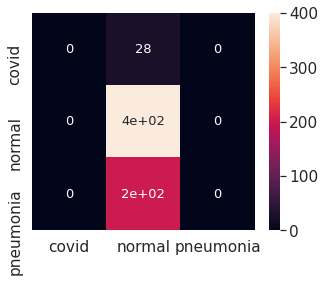

In [0]:
print("\r\n""________Validation Confusion Matrix, Precision, Recall, F1-Score__________""\r\n")
print("resnet18_entire_withFocalLoss_Valid_confusion_Matrix")
conf_matrix(model,validloader)

--------------Train Ground truth and predicted with Focalloss--------------



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


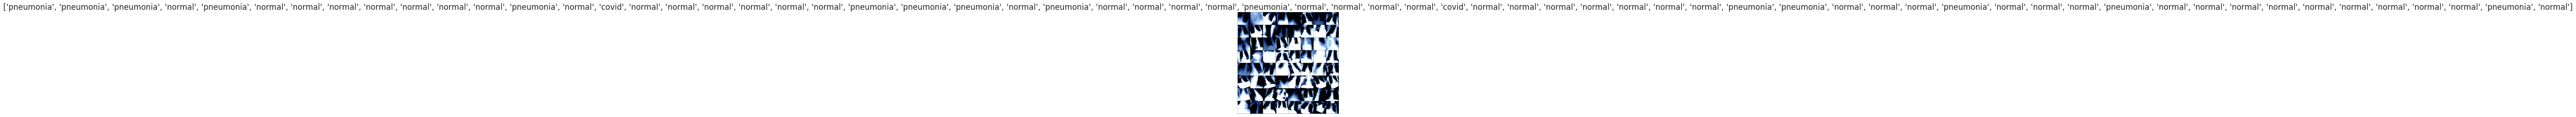

Predicted:  normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal
Ground Truth:  pneumonia pneumonia pneumonia normal pneumonia normal normal normal normal normal normal normal pneumonia normal covid normal normal normal normal normal normal pneumonia pneumonia pneumonia normal pneumonia normal normal normal normal pneumonia normal normal normal normal covid normal normal normal normal normal normal normal pneumonia pneumonia normal normal normal pneumonia normal normal normal pneumonia normal normal normal normal normal normal normal normal normal pneumonia normal

--------------Validation  Ground 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


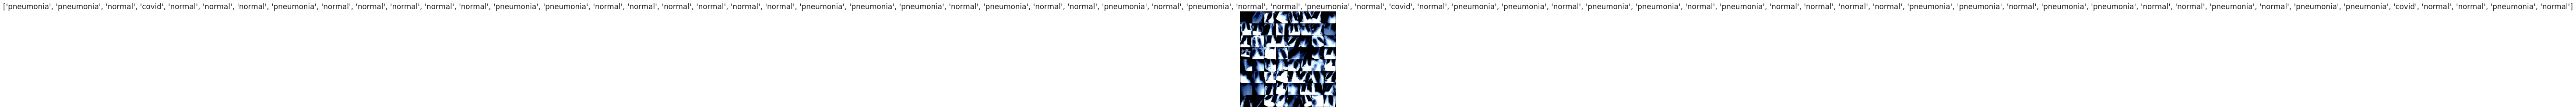

Predicted:  normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal normal
Ground Truth:  pneumonia pneumonia normal covid normal normal normal pneumonia normal normal normal normal normal pneumonia pneumonia normal normal normal normal normal normal pneumonia pneumonia pneumonia normal pneumonia normal normal pneumonia normal pneumonia normal normal pneumonia normal covid normal pneumonia pneumonia normal pneumonia pneumonia normal pneumonia normal normal normal normal pneumonia pneumonia normal pneumonia pneumonia normal normal pneumonia normal pneumonia pneumonia covid normal normal pneumonia normal


In [0]:
print("--------------Train Ground truth and predicted with Focalloss--------------""\r\n")
gtp(resnet18,trainloader)

print("\r\n""--------------Validation  Ground truth and predicted with Focalloss--------------""\r\n")
gtp(resnet18,validloader)


# With BCEWithLogits Loss